__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count

import matplotlib.pyplot as plt  # mother of plots focr Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display  # print nicely
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [2]:
warnings.filterwarnings("ignore")
# set default float display format to 2 decimals
pd.options.display.float_format = "{:.2f}".format

STYLE = "darkgrid"
sns.set_style(STYLE)  # set seaborn plotting style

PATH_COLLS = "./data/colliders"
PATH_GAZES = "./data/gazes"
PATH_HITS = "./data/hits"

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 16


__Helper functions__

In [3]:
def pbar_fork_hack():
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    print(" ", end="", flush=True)


def angle(a, b):
    """
    Angle (in degrees) between two vectors.

    Given two 3D vectors (a and b):
    a = [xa, ya, za] , b = [xb, yb, zb]

    And the basic geometric formula for the dot product:
    a · b = |a| * |b| * cos(α) => α = arccos[(a · b) / (|a| * |b|)]

    In other words:
    angle = arccos[(xa * xb + ya * yb + za * zb) / (√(xa2 + ya2 + za2) * √(xb2 + yb2 + zb2))]

    Source: https://www.omnicalculator.com/math/angle-between-two-vectors

    Parameters:
        a (numpy.array): First vector
        b (numpy.array): Second vector
    Returns:
        float: Angle between vectors a and b in degrees.
    """
    # a · b
    dotp = np.dot(a, b)

    # magnitude vectors |a| and |b|
    m_a = np.linalg.norm(a)
    m_b = np.linalg.norm(b)

    # |a| * |b|
    m_prod = m_a * m_b

    # (a * b) / (|a| * |b|)
    res = dotp / m_prod

    # α = arccos[(a · b) / (|a| * |b|)]
    an = np.arccos(res)

    # calculated angle from radians to degrees
    return np.degrees(an)

__Read participants cleaned data__

In [4]:
parts = pd.read_csv("./data/participants.csv", keep_default_na=False)
parts = parts.set_index("uid")  # set uid column as index (remove default)
parts

,date,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR,expo,file,created,condition,frames
uid,,,,,,,,,,,,,,,,
ec61bab6e46741969bceb80ee2246983,2019-05-26 12:06:22,50,50,50,50,intersex,25,1,80,58,more than 10 times,MSW,Path_ MS Wissenschaft-RadioTalk-ec61bab6e46741...,10.03.2020 01:11,RadioTalk,3070
1fbde03890d94bddaf7aa987fc732607,2019-05-26 16:02:45,100,100,100,96,Male,13,0,0,5,once,MSW,Path_ MS Wissenschaft-RadioTalk-1fbde03890d94b...,18.02.2020 16:24,RadioTalk,3070
1ad9eea672a94518b150925bac41fcbc,2019-05-26 17:23:38,17,22,0,86,Female,24,0,4,2,once,MSW,Path_ MS Wissenschaft-RadioTalk-1ad9eea672a945...,09.03.2020 21:31,RadioTalk,3070
461b2d80132f47958e50003c16084cf4,2019-05-26 17:27:34,30,70,80,80,Male,22,0,3,1,less than 10 times,MSW,Path_ MS Wissenschaft-TaxiDriver-461b2d80132f4...,10.03.2020 02:40,TaxiDriver,3070
4f300efb4a9941f7a96f57e8030b12e2,2019-05-26 17:39:25,100,100,50,50,Male,16,0,0,3,less than 10 times,MSW,Path_ MS Wissenschaft-RadioTalk-4f300efb4a9941...,09.03.2020 22:19,RadioTalk,3070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,2019-12-23 09:23:08,65,30,33,20,Male,12,0,0,25,once,BMBF,Path_ MS Wissenschaft-RadioTalk-eda9175e9e1d41...,24.01.2020 13:28,RadioTalk,3070
b8c9e625f07444cc8d4a0fc245bab5dd,2019-12-23 09:28:25,100,50,50,100,Female,12,1,99,9,less than 10 times,BMBF,Path_ MS Wissenschaft-TaxiDriver-b8c9e625f0744...,24.01.2020 15:06,TaxiDriver,3070
2cd78ad9a37945de9f8cfd5f81c42082,2019-12-27 12:56:23,86,20,71,69,Male,57,0,39,0,never,BMBF,Path_ MS Wissenschaft-RadioTalk-2cd78ad9a37945...,24.01.2020 11:49,RadioTalk,3070


Participant data example to process

In [193]:
df_part = pd.read_csv(
    f"{PATH_COLLS}/{parts.iloc[0].file}", keep_default_na=False
)
df_part = df_part.set_index("frameNumber")
df_part.head(50)

,trackerPosition,trackerRotation,centerHit,centerHitPosition,centerHitGroup,boxHit,boxHitPosition,boxHitGroup,presentObjectName,presentObjectGroup
frameNumber,,,,,,,,,,
400,"(-193.8, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(59.2, 108.8, -150.2)",WestRide Buildings,TS1 Stand Medium,"(-141.6, 98.5, -135.4)",WestRide Traffic,Building01*Building 4*Building 3*TS1_Stand_Med...,WestRide Buildings*WestRide Buildings*WestRide...
401,"(-193.8, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(59.2, 110.2, -149.6)",WestRide Buildings,TS1 Stand Medium,"(-141.6, 98.8, -135.4)",WestRide Traffic,Building01*Building 4*Building 3*TS1_Stand_Med...,WestRide Buildings*WestRide Buildings*WestRide...
402,"(-193.7, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(59.2, 111.8, -147.6)",WestRide Buildings,TS1 Stand Medium,"(-141.6, 99.2, -135.4)",WestRide Traffic,Building 3*TS1_Stand_Medium_LOD0*Square_Sign_L...,WestRide Buildings*WestRide Traffic*WestRide T...
403,"(-193.7, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(59.2, 114.3, -143.0)",WestRide Buildings,Circle_Sign_LOD0,"(-141.2, 101.2, -135.1)",WestRide Traffic,Building 3*TS1_Stand_Medium_LOD0*Square_Sign_L...,WestRide Buildings*WestRide Traffic*WestRide T...
404,"(-193.7, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(62.3, 115.7, -137.6)",WestRide Buildings,Circle_Sign_LOD0,"(-141.2, 101.2, -135.1)",WestRide Traffic,Building 3*TS1_Stand_Medium_LOD0*Square_Sign_L...,WestRide Buildings*WestRide Traffic*WestRide T...
405,"(-193.6, 102.3, -131.7)","(0.0, 0.7, 0.1, 0.7)",null,"(0.0, 0.0, 0.0)",null,Circle_Sign_LOD0,"(-141.2, 101.2, -135.1)",WestRide Traffic,Building 3*TS1_Stand_Medium_LOD0*Square_Sign_L...,WestRide Buildings*WestRide Traffic*WestRide T...
406,"(-193.5, 102.3, -131.7)","(0.0, 0.7, 0.1, 0.7)",null,"(0.0, 0.0, 0.0)",null,Circle_Sign_LOD0,"(-141.2, 101.2, -135.1)",WestRide Traffic,Building 3*TS1_Stand_Medium_LOD0*Square_Sign_L...,WestRide Buildings*WestRide Traffic*WestRide T...
407,"(-193.5, 102.3, -131.7)","(0.0, 0.7, 0.1, 0.7)",null,"(0.0, 0.0, 0.0)",null,Circle_Sign_LOD0,"(-141.2, 101.2, -135.1)",WestRide Traffic,Building 3*TS1_Stand_Medium_LOD0*Square_Sign_L...,WestRide Buildings*WestRide Traffic*WestRide T...
408,"(-193.4, 102.3, -131.7)","(0.0, 0.7, 0.1, 0.7)",Building 3,"(99.3, 116.6, -137.6)",WestRide Buildings,Circle_Sign_LOD0,"(-141.2, 101.2, -135.1)",WestRide Traffic,Building 3*TS1_Stand_Medium_LOD0*Square_Sign_L...,WestRide Buildings*WestRide Traffic*WestRide T...


Process all participants counting and groupping consecutive hitpoints

In [6]:
def check_consecutive(uid):
    """
    Process a participant hit-related information given an id.

    Compute the total of consecutive hits, nulls and store it into a shared-memory array.
    Compute and store nose vectors, distances, and angles into a CSV.
    Compute and store saccade/fixation/gaze events information.

    Parameters:
        uid (str): Participant identifier.
    """

    # participant colliders filename
    file = parts.loc[uid].file
    # index of the participant to match the array row on the hits calculations
    idx = parts.index.get_loc(uid)
    p = pd.read_csv(f"{PATH_COLLS}/{file}", keep_default_na=False)

    # use previous logic to select the right column
    hlabel = "centerHit"

    # participant hits dict to fill out and generate a df in the end
    cons = {
        "frameNumber": [],
        # trackerPosition
        "trackerX": [],
        "trackerY": [],
        "trackerZ": [],
        # nose vector between trackerPosition and center/boxHit
        "noseVectorX": [],
        "noseVectorY": [],
        "noseVectorZ": [],
        # angle between consecutive nose vectors
        "angle": [],
        # euclidean distance between HitPosition and trackerPosition
        "noseDistance": [],
        # euclidean distance between consecutive hitPositions
        "objectDistance": [],
    }

    # dicts to store gaze-event related information
    gazes = {
        "firstFrame": [],
        "lastFrame": [],
        "hits": [],
        "object": [],
        "group": [],
    }

    # create dicts to keep up with center and box hits counters:
    # hit previous (p), current (c), next(n)
    hit = {"p": None, "c": None, "n": None, "cnt": 0}

    # initialize box and center nose vector and hitPosition temporary lists
    vector = []
    hitpos = []
    frames = []
    N = p.index.size
    for i in range(N):  # iterate over all samples (frames)
        # parse trackerPosition (x, y, z)
        x, y, z = (
            p.iloc[i].trackerPosition.split("(")[1].split(")")[0].split(",")
        )
        hit["p"] = hit["c"]
        hit["c"] = p.iloc[i][hlabel]
        # because the comparison is between previous, current and next frame
        # and for the first frame the previous is anyways null (default init)
        if i + 1 < N:
            hit["n"] = p.iloc[i + 1].centerHit
        if hit["c"] != "null":  # current centerHit sample is not "null"
            # store it
            cons["trackerX"].append(x)
            cons["trackerY"].append(y)
            cons["trackerZ"].append(z)
            # hitPosition coordinates
            x1, y1, z1 = (
                p.iloc[i]
                .centerHitPosition.split("(")[1]
                .split(")")[0]
                .split(",")
            )
            # origin -> nose vector starting point, end -> NV ending point
            origin = np.array([float(x), float(y), float(z)])
            end = np.array([float(x1), float(y1), float(z1)])
            # store hit positions on objects to compute distances between them
            hitpos.append(end)
            # compute and store the nose vector for consecutive hits
            nose = end - origin  # same as np.subtract(end, origin)
            vector.append(nose)
            curr_frame = p.iloc[i].frameNumber
            cons["frameNumber"].append(curr_frame)
            frames.append(curr_frame)
            # euclidean distance between origin and end points (nose vector)
            dist = np.linalg.norm(nose)
            cons["noseDistance"].append(dist)  # store it
            # initialize to 1 if previous and current object names differ
            # otherwise increment
            hit["cnt"] = 1 if hit["p"] != hit["c"] else hit["cnt"] + 1
            # when no more consecutives (current and next are different)
            if hit["c"] != hit["n"] or i == N - 1:
                # increment consecutive hits for the given participant
                hits[idx, hit["cnt"]] += 1
                if len(vector) > 1:  # more than 1 (consecutive) hit
                    for v, _ in enumerate(vector):
                        # store coordinates of consecutive nose vectors
                        cons["noseVectorX"].append(vector[v][0])
                        cons["noseVectorY"].append(vector[v][1])
                        cons["noseVectorZ"].append(vector[v][2])
                        # add initial angle as 0 as always current - previous
                        if v == 0:
                            cons["angle"].append(0.0)
                            cons["objectDistance"].append(0.0)
                        if v < len(vector) - 1:
                            # select current and next vector
                            v0 = vector[v]
                            v1 = vector[v + 1]
                            # (v0 == v1).all() same as np.array_equal(v0, v1)
                            # calculate angle only if the vectors differ
                            an = 0.0 if (v0 == v1).all() else angle(v0, v1)
                            cons["angle"].append(an)
                            h0 = hitpos[v]
                            h1 = hitpos[v + 1]
                            # calculate hit distance only if coordinates differ
                            hdiff = not (h0 == h1).all()
                            # same as h1 - h0
                            di = np.linalg.norm(h0 - h1) if hdiff else 0.0
                            cons["objectDistance"].append(di)
                else:  # for 1 hit
                    # store the nose vector and the rest as zeros (avoid NaNs)
                    cons["noseVectorX"].append(vector[0][0])
                    cons["noseVectorY"].append(vector[0][1])
                    cons["noseVectorZ"].append(vector[0][2])
                    cons["angle"].append(0.0)
                    cons["objectDistance"].append(0.0)
                gazes["firstFrame"].append(frames[0])
                gazes["lastFrame"].append(frames[-1])
                gazes["hits"].append(len(frames))
                gazes["object"].append(p.iloc[i][hlabel])
                gazes["group"].append(p.iloc[i][f"{hlabel}Group"])
                # reset consecutive counter and temporary nose vector lists
                hit["cnt"] = 0
                vector = []
                hitpos = []
                frames = []
        else:
            # increment the number of consecutive hits for the participant
            hits[idx, 0] += 1
            # reset consecutive counter and current object name
            hit["cnt"] = 0
            hit["c"] = None
            # reset consecutive counter and temporary nose vector lists
            vector = []
            hitpos = []
            frames = []

    # hits and gaze dicts to df
    df_cons = pd.DataFrame(cons)
    df_gazes = pd.DataFrame(gazes)
    # store participant processed data as csv
    df_cons.to_csv(f"{PATH_HITS}/{file}", index=False)
    df_gazes.to_csv(f"{PATH_GAZES}/{file}", index=False)


# define our iterable using a generator
uids = parts.index.tolist()
uids_len = len(uids)
uids_gen = (u for u in uids)

# since the experiment lasts 90 seconds
# the maximum, although not really possible, n_samples
# looking at the same object/spot would be 90s * 30FPS = 2700
# but the index size of each participant it's actually 2671
MAX = df_part.index.size

# duplicate array (for box and center hits)
# shared memory Array(ctype_or_ctype_code, size or initializer)
# only 1D arrays allowed, it will create an array of uids_len x N of zeros
hits = RawArray("i", uids_len * MAX)
# each row will represent the consecutive hits computed per participant
# thus wrap it as a np array for [row, col] slicing and indexing convenience
hits = np.frombuffer(hits, dtype=np.int32).reshape((uids_len, MAX))

pool = Pool(processes=CORES)

# participants progress bar
parts_progress = tqdm(
    iterable=pool.imap_unordered(func=check_consecutive, iterable=uids_gen),
    total=uids_len,
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_progress:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()
# parts_progress.close()  # only needed when the pbar is updated manually

📄 0 of 7913 📂 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Parse the consecutive hits calculations as a dataframe

In [7]:
cols = [i for i in range(MAX)]  # generate cols (0-N)
# add two extra columns at the beginning of the list
cols.insert(0, "uid")  # first col

# empty df with given cols
df_center = pd.DataFrame(columns=cols)

# progress bar from participants uid list
progress = tqdm(
    iterable=parts.index.tolist(),
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# dict to store center and box consecutive hit counters
hits_c = {i: [] for i in range(MAX)}
# include keys to store participant uid and hit type (center/box)
hits_c["uid"] = []

# iterate over each participant while updating the pbar
for idx, part in enumerate(progress):
    # store participant hit counters (center and box)
    for i in range(MAX):
        hits_c[i].append(hits[idx, i])
    # store participant uid and hit type
    hits_c["uid"].append(part)

# add all participants hit counters to the empty dataframe
df_center = df_center.append(pd.DataFrame(hits_c), ignore_index=True)

df_center.to_csv("./data/center_hits.csv", index=False)

df_center

📄 0 of 7913 📂 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

,uid,0,1,2,3,4,5,6,7,8,...,2661,2662,2663,2664,2665,2666,2667,2668,2669,2670
0,ec61bab6e46741969bceb80ee2246983,833,45,15,8,9,12,2,4,2,...,0,0,0,0,0,0,0,0,0,0
1,1fbde03890d94bddaf7aa987fc732607,2527,15,7,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1ad9eea672a94518b150925bac41fcbc,601,62,31,13,12,9,2,9,1,...,0,0,0,0,0,0,0,0,0,0
3,461b2d80132f47958e50003c16084cf4,1929,23,9,2,6,4,6,4,1,...,0,0,0,0,0,0,0,0,0,0
4,4f300efb4a9941f7a96f57e8030b12e2,2649,7,1,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,eda9175e9e1d4153ac2ca3038b2ab008,1344,90,25,18,17,6,10,4,4,...,0,0,0,0,0,0,0,0,0,0
7909,b8c9e625f07444cc8d4a0fc245bab5dd,1156,53,21,9,9,4,8,5,6,...,0,0,0,0,0,0,0,0,0,0
7910,2cd78ad9a37945de9f8cfd5f81c42082,2382,43,10,2,4,5,5,3,2,...,0,0,0,0,0,0,0,0,0,0
7911,dba04b626e4c4c6e89aea4fb1f9cc32b,437,1,3,2,2,3,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_chits = pd.read_csv("./data/center_hits.csv")

In [9]:
df_chits

,uid,0,1,2,3,4,5,6,7,8,...,2661,2662,2663,2664,2665,2666,2667,2668,2669,2670
0,ec61bab6e46741969bceb80ee2246983,833,45,15,8,9,12,2,4,2,...,0,0,0,0,0,0,0,0,0,0
1,1fbde03890d94bddaf7aa987fc732607,2527,15,7,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1ad9eea672a94518b150925bac41fcbc,601,62,31,13,12,9,2,9,1,...,0,0,0,0,0,0,0,0,0,0
3,461b2d80132f47958e50003c16084cf4,1929,23,9,2,6,4,6,4,1,...,0,0,0,0,0,0,0,0,0,0
4,4f300efb4a9941f7a96f57e8030b12e2,2649,7,1,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,eda9175e9e1d4153ac2ca3038b2ab008,1344,90,25,18,17,6,10,4,4,...,0,0,0,0,0,0,0,0,0,0
7909,b8c9e625f07444cc8d4a0fc245bab5dd,1156,53,21,9,9,4,8,5,6,...,0,0,0,0,0,0,0,0,0,0
7910,2cd78ad9a37945de9f8cfd5f81c42082,2382,43,10,2,4,5,5,3,2,...,0,0,0,0,0,0,0,0,0,0
7911,dba04b626e4c4c6e89aea4fb1f9cc32b,437,1,3,2,2,3,0,1,1,...,0,0,0,0,0,0,0,0,0,0


Get rid of columns with only zeros (no consecutive hits) from right (biggest) to left (smallest) until first non-zero encountered

In [10]:
cols = df_chits.columns.to_list()  # cols of this df
cols.reverse()  # reverse the order of the columns

# CENTER HITS
# prepare manually updated progressbar
progress = tqdm(total=len(cols))
for col in cols:  # iterate over df columns
    # drop column if sum is zero, otherwise stop iterating
    if df_chits[col].sum() == 0:
        df_chits = df_chits.drop(col, axis=1)
        progress.update()  # update pbar (+1 iteration)
    else:
        # update pbar to 100% (more satisfying)
        progress.update(len(cols) - progress.n)  # total iters - current
        progress.close()  # close pbar
        break

# store as csv and display
df_chits.to_csv("./data/center_hits.csv", index=False)
df_chits

  0%|          | 0/2672 [00:00<?, ?it/s]

,uid,0,1,2,3,4,5,6,7,8,...,662,663,664,665,666,667,668,669,670,671
0,ec61bab6e46741969bceb80ee2246983,833,45,15,8,9,12,2,4,2,...,0,0,0,0,0,0,0,0,0,0
1,1fbde03890d94bddaf7aa987fc732607,2527,15,7,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1ad9eea672a94518b150925bac41fcbc,601,62,31,13,12,9,2,9,1,...,0,0,0,0,0,0,0,0,0,0
3,461b2d80132f47958e50003c16084cf4,1929,23,9,2,6,4,6,4,1,...,0,0,0,0,0,0,0,0,0,0
4,4f300efb4a9941f7a96f57e8030b12e2,2649,7,1,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,eda9175e9e1d4153ac2ca3038b2ab008,1344,90,25,18,17,6,10,4,4,...,0,0,0,0,0,0,0,0,0,0
7909,b8c9e625f07444cc8d4a0fc245bab5dd,1156,53,21,9,9,4,8,5,6,...,0,0,0,0,0,0,0,0,0,0
7910,2cd78ad9a37945de9f8cfd5f81c42082,2382,43,10,2,4,5,5,3,2,...,0,0,0,0,0,0,0,0,0,0
7911,dba04b626e4c4c6e89aea4fb1f9cc32b,437,1,3,2,2,3,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [184]:
sns.set_context("paper", font_scale=2.0)
df_chits = pd.read_csv("./data/center_hits.csv")
df_chits

,uid,0,1,2,3,4,5,6,7,8,...,662,663,664,665,666,667,668,669,670,671
0,ec61bab6e46741969bceb80ee2246983,833,45,15,8,9,12,2,4,2,...,0,0,0,0,0,0,0,0,0,0
1,1fbde03890d94bddaf7aa987fc732607,2527,15,7,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1ad9eea672a94518b150925bac41fcbc,601,62,31,13,12,9,2,9,1,...,0,0,0,0,0,0,0,0,0,0
3,461b2d80132f47958e50003c16084cf4,1929,23,9,2,6,4,6,4,1,...,0,0,0,0,0,0,0,0,0,0
4,4f300efb4a9941f7a96f57e8030b12e2,2649,7,1,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,eda9175e9e1d4153ac2ca3038b2ab008,1344,90,25,18,17,6,10,4,4,...,0,0,0,0,0,0,0,0,0,0
7909,b8c9e625f07444cc8d4a0fc245bab5dd,1156,53,21,9,9,4,8,5,6,...,0,0,0,0,0,0,0,0,0,0
7910,2cd78ad9a37945de9f8cfd5f81c42082,2382,43,10,2,4,5,5,3,2,...,0,0,0,0,0,0,0,0,0,0
7911,dba04b626e4c4c6e89aea4fb1f9cc32b,437,1,3,2,2,3,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [185]:
# all columns except for nulls counter (0), and hitType
# gazes = list(df_chits.describe().columns.difference(["0"]))
gaze_cols = [str(i) for i in range(8, 672)]
saccades = [str(i) for i in range(1, 8)]
hits_cper = {"nulls": [], "saccades": [], "gazes": []}
pbar = tqdm(iterable=df_chits.index.values)
for row in pbar:
    curr_c = df_chits.loc[row]
    restc = curr_c["0"] * 100 / 2671
    saccc = sum([int(col) * curr_c[col] * 100 / 2671 for col in saccades])
    gazec = sum([int(col) * curr_c[col] * 100 / 2671 for col in gaze_cols])
    hits_cper["nulls"].append(restc)
    hits_cper["saccades"].append(saccc)
    hits_cper["gazes"].append(gazec)

  0%|          | 0/7913 [00:00<?, ?it/s]

In [186]:
hits_cper = pd.DataFrame(hits_cper)

,nulls,saccades,gazes
0,31.19,8.80,60.01
1,94.61,1.83,3.56
2,22.50,12.39,65.11
3,72.22,5.80,21.98
4,99.18,0.82,0.00
...,...,...,...
7908,50.32,14.23,35.45
7909,43.28,9.77,46.95
7910,89.18,6.03,4.79
7911,16.36,1.61,82.03


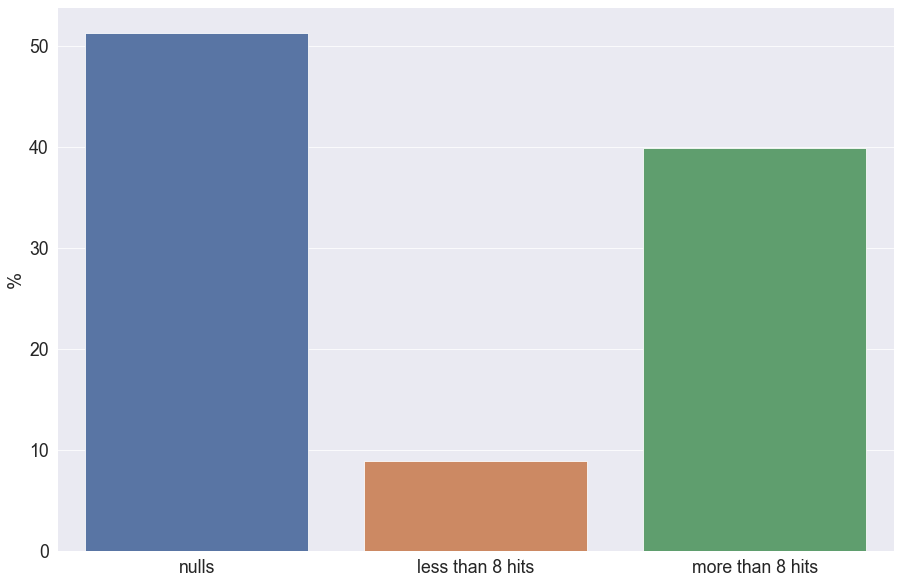

In [187]:
# display(hits_ccount)
# hits_ccount["nulls %"] = hits_ccount["nulls"] / 2671 * 100
# hits_ccount["hits %"] = hits_ccount["hits"] / 2671 * 100
plt.figure(figsize=(15, 10))
display(hits_cper)
# sns.histplot(hits_cper, stat="density")
# plt.show()
hits_cper.mean()
ax = sns.barplot(
    y=hits_cper.mean(), x=["nulls", "less than 8 hits", "more than 8 hits"]
)
ax.set_ylabel("%")
plt.show()

In [188]:
# all columns except for nulls counter (0), and hitType
cols = list(df_chits.describe().columns.difference(["0"]))
hits_ccount = {"uid": [], "nulls": [], "hits": []}
pbar = tqdm(iterable=df_chits.index.values)
for row in pbar:
    curr_c = df_chits.loc[row]
    hits_ccount["uid"].append(curr_c.uid)
    hits_ccount["nulls"].append(curr_c["0"])
    totalc = sum([int(col) * curr_c[col] for col in cols])
    hits_ccount["hits"].append(totalc)

hits_ccount = pd.DataFrame(hits_ccount)

  0%|          | 0/7913 [00:00<?, ?it/s]

In [189]:
# display(hits_ccount)
hits_ccount["nulls %"] = hits_ccount["nulls"] / 2671 * 100
hits_ccount["hits %"] = hits_ccount["hits"] / 2671 * 100
hits_ccount

,uid,nulls,hits,nulls %,hits %
0,ec61bab6e46741969bceb80ee2246983,833,1838,31.19,68.81
1,1fbde03890d94bddaf7aa987fc732607,2527,144,94.61,5.39
2,1ad9eea672a94518b150925bac41fcbc,601,2070,22.50,77.50
3,461b2d80132f47958e50003c16084cf4,1929,742,72.22,27.78
4,4f300efb4a9941f7a96f57e8030b12e2,2649,22,99.18,0.82
...,...,...,...,...,...
7908,eda9175e9e1d4153ac2ca3038b2ab008,1344,1327,50.32,49.68
7909,b8c9e625f07444cc8d4a0fc245bab5dd,1156,1515,43.28,56.72
7910,2cd78ad9a37945de9f8cfd5f81c42082,2382,289,89.18,10.82
7911,dba04b626e4c4c6e89aea4fb1f9cc32b,437,2234,16.36,83.64


In [190]:
perc_ccount = hits_ccount[["nulls %", "hits %"]]
melted = pd.melt(perc_ccount)
melted = melted[melted["variable"] != "uid"]

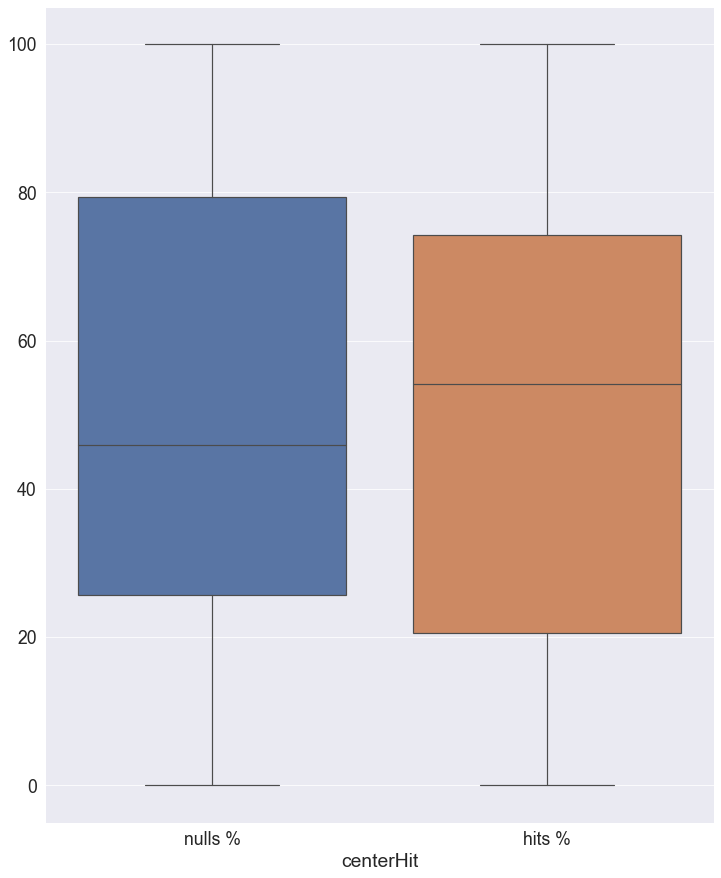

In [194]:
plt.figure(figsize=(12, 15))
ax = sns.boxplot(data=melted, x="variable", y="value")
ax.set(xlabel="centerHit", ylabel="")
plt.show()

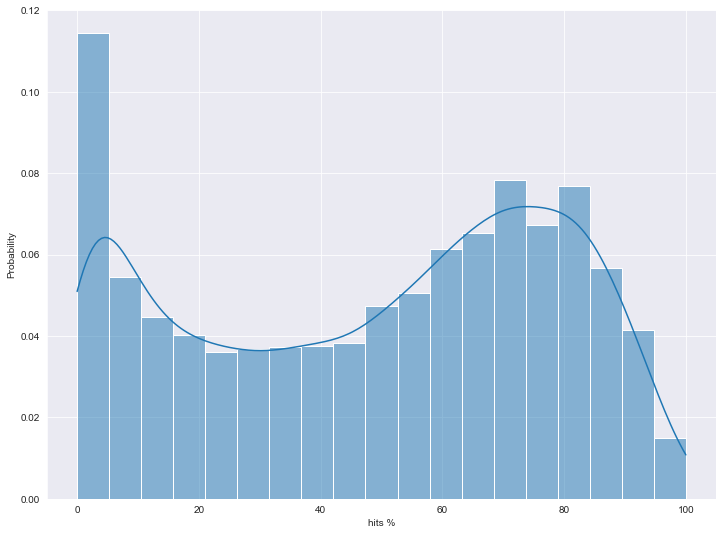

In [19]:
plt.figure(figsize=(12, 9))
sns.histplot(data=perc_ccount["hits %"], stat="probability", kde=True)
plt.show()

Get all possible HitGroups

In [35]:
uids = parts.index.tolist()
hit_groups = []

# participants progress bar
parts_progress = tqdm(
    iterable=uids,
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for uid in parts_progress:
    file = parts.loc[sample_uid].file
    p = pd.read_csv(f"{PATH_GAZES}/{file}", keep_default_na=False)
    groups = p.group.unique()
    for g in groups:
        if g not in hit_groups:
            hit_groups.append(g)

hit_groups

📄 0 of 7913 📂 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

['WestRide Buildings', 'WestRide Traffic', 'PedestriansManager', 'CarsManager']

In [51]:
def check_gazes(uid):
    """
    Process a participant gaze-related information given an id.

    Parameters:
        uid (str): Participant identifier.
    """
    # participant colliders filename
    file = parts.loc[uid].file
    # index of the participant to match the array row on the hits calculations
    idx = parts.index.get_loc(uid)
    p = pd.read_csv(f"{PATH_GAZES}/{file}", keep_default_na=False)
    # select only gaze events
    p = p[p.hits > 7]
    # hitGroup value counts
    gazes = p.group.value_counts(normalize=True)
    for g in gazes.index.tolist():
        # norm value to percentage
        perc = gazes.loc[g]
        # index of the hitGroup
        col = hit_groups.index(g)
        g_events[idx, col] = perc
    # calculate traffic-relevant percentage (100 - non-TR)
    tr_perc = 100.0 - g_events[idx, NON_TR_COL]
    g_events[idx, len(hit_groups) - 1] = tr_perc


# include traffic-relevant column
hit_groups = [
    "WestRide Buildings",
    "WestRide Traffic",
    "PedestriansManager",
    "CarsManager",
    "Events",
    "TR",
]

NON_TR_COL = hit_groups.index("WestRide Buildings")

# define our iterable using a generator
uids = parts.index.tolist()
uids_len = len(uids)
uids_gen = (u for u in uids)

pool = Pool(processes=CORES, initializer=pbar_fork_hack)

NCOLS = len(hit_groups)

# shared memory Array(ctype_or_ctype_code, size or initializer)
# only 1D arrays allowed, it will create an array of uids_len x N of zeros
g_events = RawArray("f", uids_len * NCOLS)
# thus wrap it as a np array for [row, col] slicing and indexing convenience
g_events = np.frombuffer(g_events, dtype=np.float32).reshape((uids_len, NCOLS))

# participants progress bar
parts_progress = tqdm(
    iterable=pool.imap_unordered(func=check_gazes, iterable=uids_gen),
    total=uids_len,
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_progress:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()
# parts_progress.close()  # only needed when the pbar is updated manually

📄 0 of 7913 📂 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

In [76]:
# define our iterable using a generator
uids = parts.index.tolist()

# include traffic-relevant column
hit_groups = [
    "WestRide Buildings",
    "WestRide Traffic",
    "PedestriansManager",
    "CarsManager",
    "Events",
]

g_events = {g: [] for g in hit_groups}

# participants progress bar
parts_progress = tqdm(
    iterable=uids,
    total=uids_len,
    desc="📂 participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for uid in parts_progress:
    # participant colliders filename
    file = parts.loc[uid].file
    # index of the participant to match the array row on the hits calculations
    idx = parts.index.get_loc(uid)
    p = pd.read_csv(f"{PATH_GAZES}/{file}", keep_default_na=False)
    # select only gaze events
    p = p[p.hits > 7]
    # hitGroup value counts
    gazes = p.group.value_counts(normalize=True)
    tr_perc = None
    for g in hit_groups:
        if g in gazes.index.tolist():
            # norm value to percentage
            perc = gazes.loc[g] * 100.0
            g_events[g].append(perc)
        else:
            g_events[g].append(0.0)

📄 0 of 7913 📂 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

In [195]:
df_gevents = pd.DataFrame(g_events, index=uids)

df_gevents["TR"] = df_gevents[
    ["WestRide Traffic", "PedestriansManager", "CarsManager", "Events"]
].sum(axis=1)
cols_to_add = ["Intention", "Usefulness", "Ease", "Trust"]

for col in cols_to_add:
    df_gevents[col] = parts[col]
    
df_gevents["condition"] = parts["condition"]

df_gevents

,WestRide Buildings,WestRide Traffic,PedestriansManager,CarsManager,Events,TR,Intention,Usefulness,Ease,Trust,condition
ec61bab6e46741969bceb80ee2246983,95.00,2.50,0.00,2.50,0.00,5.00,50,50,50,50,RadioTalk
1fbde03890d94bddaf7aa987fc732607,66.67,0.00,16.67,0.00,16.67,33.33,100,100,100,96,RadioTalk
1ad9eea672a94518b150925bac41fcbc,97.62,2.38,0.00,0.00,0.00,2.38,17,22,0,86,RadioTalk
461b2d80132f47958e50003c16084cf4,100.00,0.00,0.00,0.00,0.00,0.00,30,70,80,80,TaxiDriver
4f300efb4a9941f7a96f57e8030b12e2,0.00,0.00,0.00,0.00,0.00,0.00,100,100,50,50,RadioTalk
...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,89.74,0.00,2.56,7.69,0.00,10.26,65,30,33,20,RadioTalk
b8c9e625f07444cc8d4a0fc245bab5dd,92.50,2.50,2.50,2.50,0.00,7.50,100,50,50,100,TaxiDriver
2cd78ad9a37945de9f8cfd5f81c42082,100.00,0.00,0.00,0.00,0.00,0.00,86,20,71,69,RadioTalk
dba04b626e4c4c6e89aea4fb1f9cc32b,100.00,0.00,0.00,0.00,0.00,0.00,84,89,61,92,TaxiDriver


Select AVAS condition

In [196]:
df_gevents = df_gevents[df_gevents.condition == "AVAS"]
df_gevents

,WestRide Buildings,WestRide Traffic,PedestriansManager,CarsManager,Events,TR,Intention,Usefulness,Ease,Trust,condition
ed5acbdcfe1143869070b6d2ee36b8b2,100.00,0.00,0.00,0.00,0.00,0.00,38,21,85,55,AVAS
a26e9aa0461b4066966b4f5283d0c4ca,66.67,0.00,0.00,0.00,33.33,33.33,50,84,78,66,AVAS
20bafe62464e4c77b7100019430e9159,100.00,0.00,0.00,0.00,0.00,0.00,98,96,97,79,AVAS
21690b016cd64275906d9dc20580087a,100.00,0.00,0.00,0.00,0.00,0.00,50,50,50,50,AVAS
f33b3bc7b42d487988ec964a288e4462,91.30,2.90,0.00,5.80,0.00,8.70,0,0,69,100,AVAS
...,...,...,...,...,...,...,...,...,...,...,...
d8e9f4f08a944f52bb9495a00101691b,90.00,0.00,10.00,0.00,0.00,10.00,7,50,86,50,AVAS
03e8e56c64b04c6e83816538be60e57c,83.33,0.00,0.00,16.67,0.00,16.67,100,50,50,50,AVAS
37ca2013daa14226b8f57cf55a670ab7,89.47,0.00,0.00,10.53,0.00,10.53,50,84,50,50,AVAS
45ee79b6ec8540d890ef8ac5e7ac23b3,98.08,0.00,1.92,0.00,0.00,1.92,50,50,50,50,AVAS


How many participants gazed 100% non-TR stimuli? (Impossible, something went wrong)

In [197]:
len(df_gevents[df_gevents["WestRide Buildings"] == 100.0])

640

Remove them from the sample

In [198]:
df_gevents = df_gevents[df_gevents["WestRide Buildings"] != 100.0]
df_gevents

,WestRide Buildings,WestRide Traffic,PedestriansManager,CarsManager,Events,TR,Intention,Usefulness,Ease,Trust,condition
a26e9aa0461b4066966b4f5283d0c4ca,66.67,0.00,0.00,0.00,33.33,33.33,50,84,78,66,AVAS
f33b3bc7b42d487988ec964a288e4462,91.30,2.90,0.00,5.80,0.00,8.70,0,0,69,100,AVAS
d2bb200ab76444bfa82f207b5f8d2111,82.76,0.00,0.00,13.79,3.45,17.24,1,9,12,6,AVAS
f3e14207871f42ab8a02e20d53616334,0.00,0.00,0.00,0.00,0.00,0.00,14,25,8,22,AVAS
92ae89bcc83348cbb80728a5980fe924,85.37,0.00,2.44,12.20,0.00,14.63,36,40,34,66,AVAS
...,...,...,...,...,...,...,...,...,...,...,...
6b3051dd9a8e41fa9f67425c4caa3be9,33.33,0.00,33.33,0.00,33.33,66.67,90,0,0,7,AVAS
d8e9f4f08a944f52bb9495a00101691b,90.00,0.00,10.00,0.00,0.00,10.00,7,50,86,50,AVAS
03e8e56c64b04c6e83816538be60e57c,83.33,0.00,0.00,16.67,0.00,16.67,100,50,50,50,AVAS
37ca2013daa14226b8f57cf55a670ab7,89.47,0.00,0.00,10.53,0.00,10.53,50,84,50,50,AVAS


Afterwards, how many participants gazed 0% TR stimuli? (Also impossible, something went wrong)

In [199]:
len(df_gevents[df_gevents["TR"] == 0.0])

85

Remove them from the sample

In [200]:
df_gevents = df_gevents[df_gevents["TR"] != 0.0]
df_gevents

,WestRide Buildings,WestRide Traffic,PedestriansManager,CarsManager,Events,TR,Intention,Usefulness,Ease,Trust,condition
a26e9aa0461b4066966b4f5283d0c4ca,66.67,0.00,0.00,0.00,33.33,33.33,50,84,78,66,AVAS
f33b3bc7b42d487988ec964a288e4462,91.30,2.90,0.00,5.80,0.00,8.70,0,0,69,100,AVAS
d2bb200ab76444bfa82f207b5f8d2111,82.76,0.00,0.00,13.79,3.45,17.24,1,9,12,6,AVAS
92ae89bcc83348cbb80728a5980fe924,85.37,0.00,2.44,12.20,0.00,14.63,36,40,34,66,AVAS
c48b2ea88bd946c4a14a5668a2caf682,70.83,8.33,8.33,8.33,4.17,29.17,76,100,100,100,AVAS
...,...,...,...,...,...,...,...,...,...,...,...
6b3051dd9a8e41fa9f67425c4caa3be9,33.33,0.00,33.33,0.00,33.33,66.67,90,0,0,7,AVAS
d8e9f4f08a944f52bb9495a00101691b,90.00,0.00,10.00,0.00,0.00,10.00,7,50,86,50,AVAS
03e8e56c64b04c6e83816538be60e57c,83.33,0.00,0.00,16.67,0.00,16.67,100,50,50,50,AVAS
37ca2013daa14226b8f57cf55a670ab7,89.47,0.00,0.00,10.53,0.00,10.53,50,84,50,50,AVAS


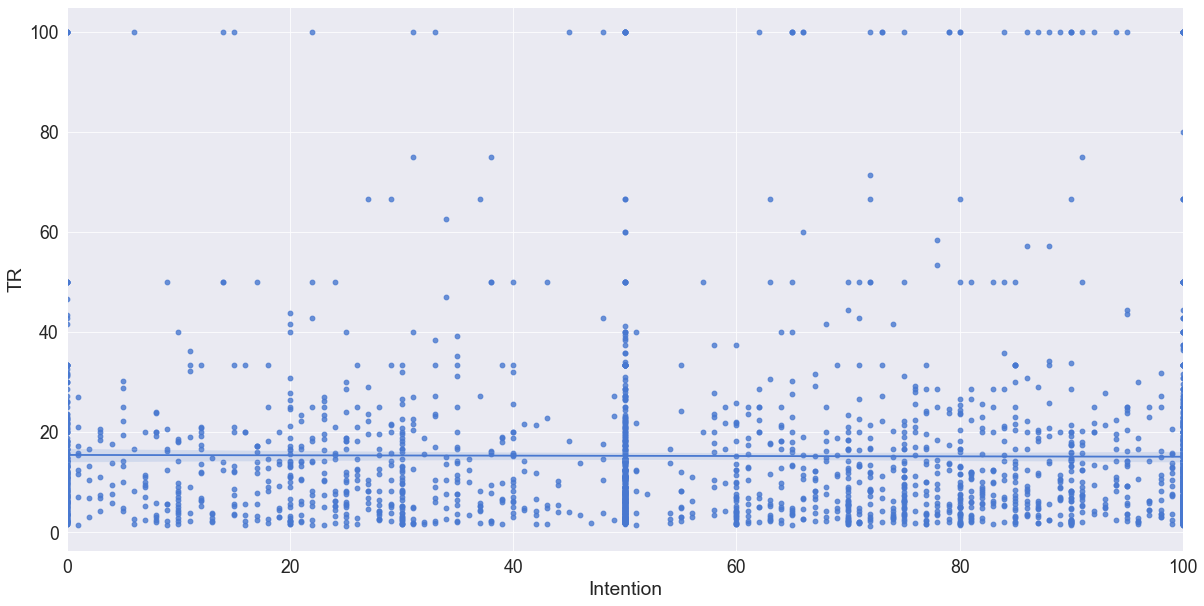

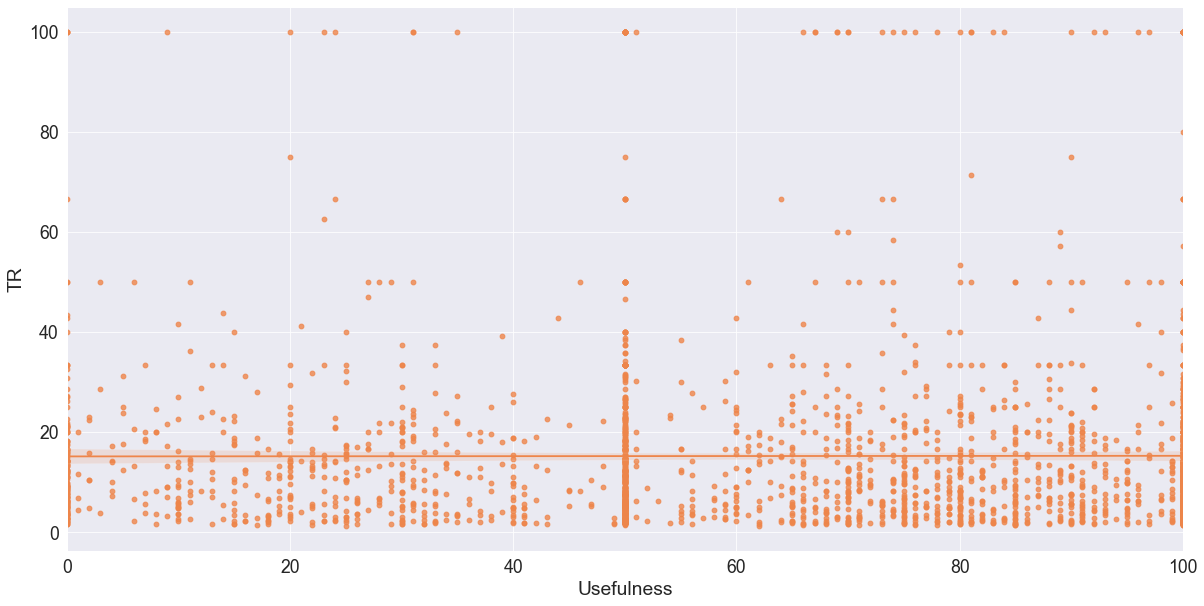

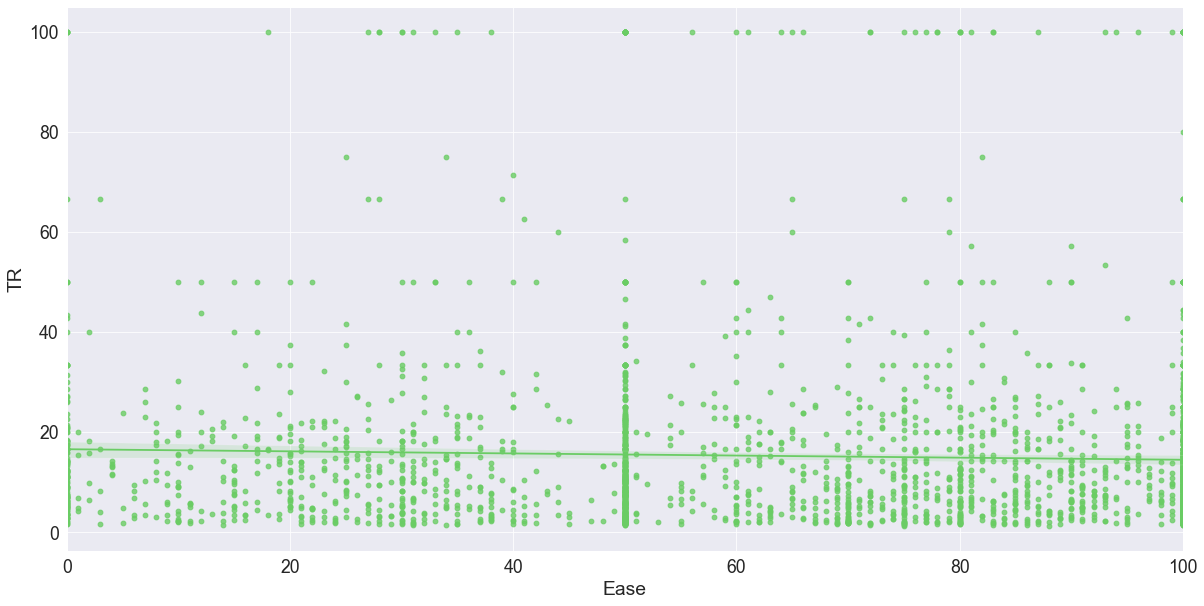

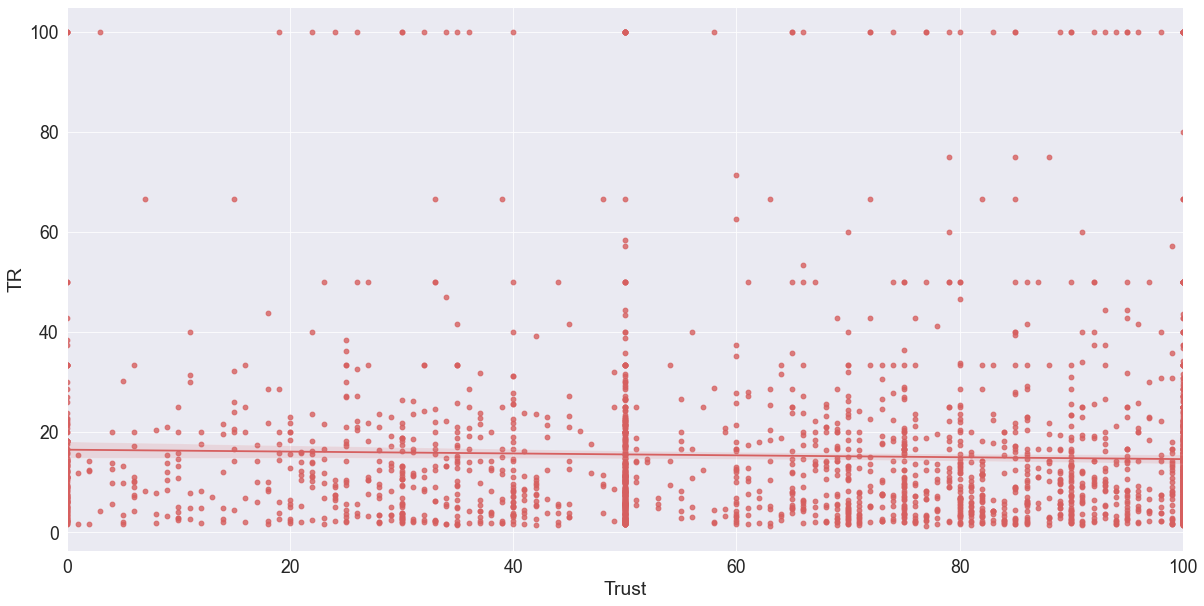

In [210]:
sns.set_context("paper", font_scale=2.0)
palette = itertools.cycle(sns.color_palette(palette="muted"))  # color palette
for col in cols_to_add:
    plt.figure(figsize=(20, 10))
    sns.regplot(data=df_gevents, y="TR", x=col, color=next(palette))
    plt.show()

In [202]:
hits_ccount

,uid,nulls,hits,nulls %,hits %
0,ec61bab6e46741969bceb80ee2246983,833,1838,31.19,68.81
1,1fbde03890d94bddaf7aa987fc732607,2527,144,94.61,5.39
2,1ad9eea672a94518b150925bac41fcbc,601,2070,22.50,77.50
3,461b2d80132f47958e50003c16084cf4,1929,742,72.22,27.78
4,4f300efb4a9941f7a96f57e8030b12e2,2649,22,99.18,0.82
...,...,...,...,...,...
7908,eda9175e9e1d4153ac2ca3038b2ab008,1344,1327,50.32,49.68
7909,b8c9e625f07444cc8d4a0fc245bab5dd,1156,1515,43.28,56.72
7910,2cd78ad9a37945de9f8cfd5f81c42082,2382,289,89.18,10.82
7911,dba04b626e4c4c6e89aea4fb1f9cc32b,437,2234,16.36,83.64


In [203]:
len(hits_ccount[hits_ccount["hits %"] >= 50])

407

In [207]:
uids_half = hits_ccount[hits_ccount["hits %"] >= 50].uid.tolist()

In [208]:
df = df_gevents.reindex(index=uids_half)
df = df.dropna()
df

,WestRide Buildings,WestRide Traffic,PedestriansManager,CarsManager,Events,TR,Intention,Usefulness,Ease,Trust,condition
f33b3bc7b42d487988ec964a288e4462,91.30,2.90,0.00,5.80,0.00,8.70,0.00,0.00,69.00,100.00,AVAS
4ce356d44e0d4470862e4ec48fc4fba7,78.43,0.00,1.96,17.65,1.96,21.57,100.00,100.00,100.00,50.00,AVAS
6760f479dc0747f18dd080d4628145f3,92.86,0.00,0.00,4.76,2.38,7.14,30.00,70.00,60.00,80.00,AVAS
9708eafdaaf04b3c80a752852ff44c4b,95.00,3.33,0.00,1.67,0.00,5.00,100.00,92.00,63.00,0.00,AVAS
0f6ec8f8945242749087037951665a6d,94.34,1.89,0.00,3.77,0.00,5.66,100.00,100.00,9.00,89.00,AVAS
...,...,...,...,...,...,...,...,...,...,...,...
f25129f74ae64b14ba3e8a4e215f6aaf,85.71,2.04,4.08,4.08,4.08,14.29,100.00,100.00,90.00,100.00,AVAS
b24d8f7b31024686915148bf3343936d,97.67,2.33,0.00,0.00,0.00,2.33,0.00,15.00,11.00,37.00,AVAS
f2980db0ea344f0a8924ca3b97142150,96.88,0.00,0.00,0.00,3.12,3.12,56.00,69.00,50.00,100.00,AVAS
44c13201c0624bfd81d8963ea8e08bde,96.55,0.00,0.00,0.00,3.45,3.45,21.00,35.00,50.00,40.00,AVAS


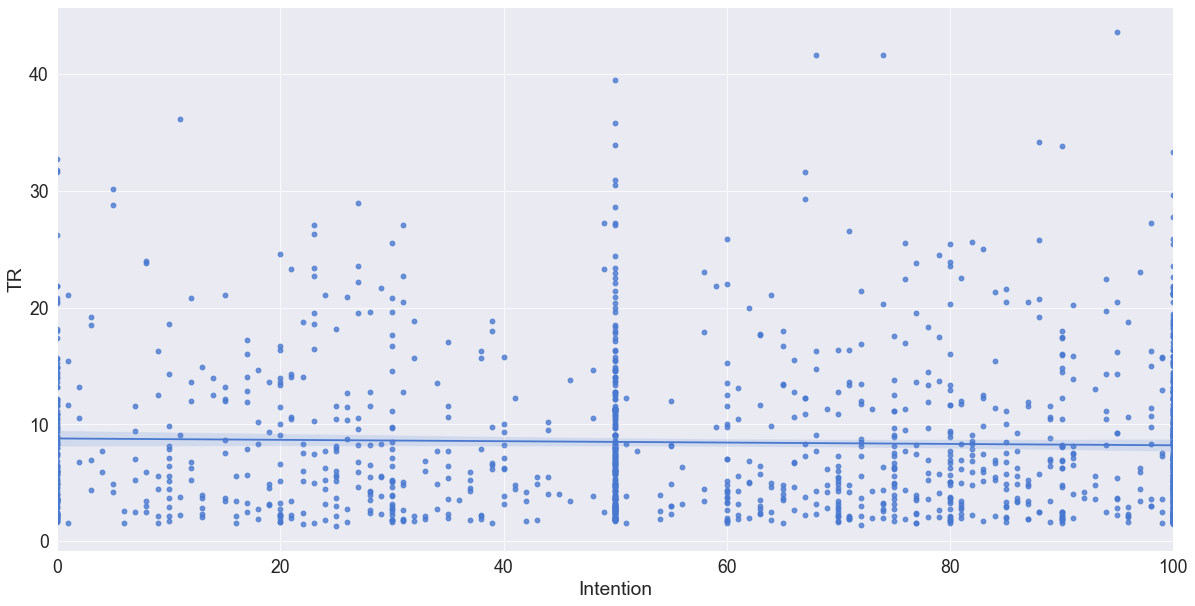

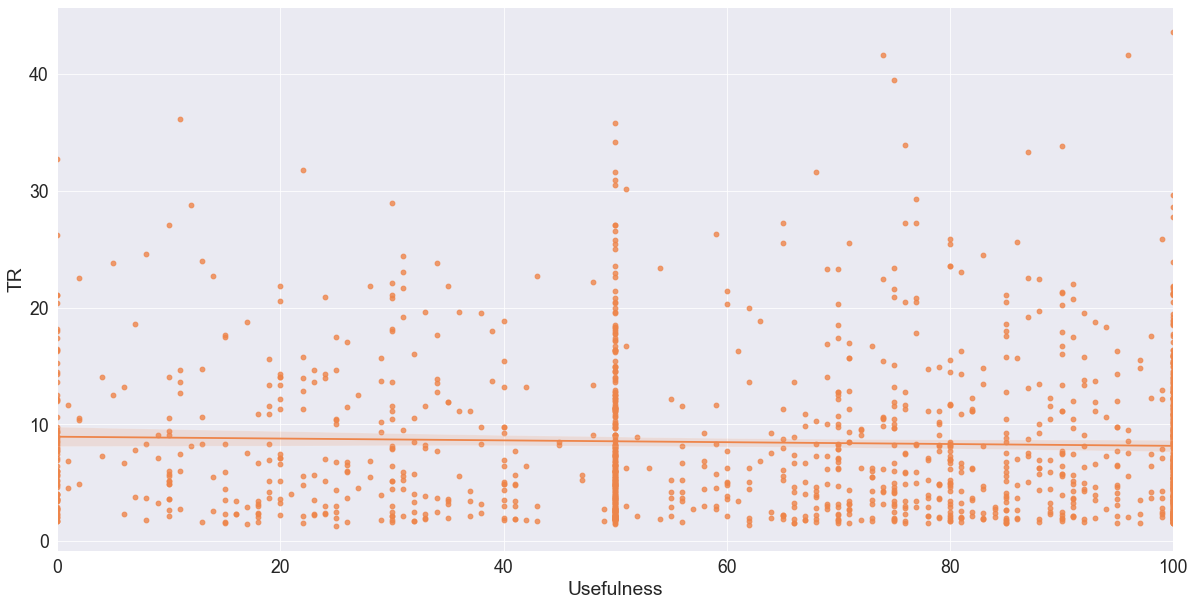

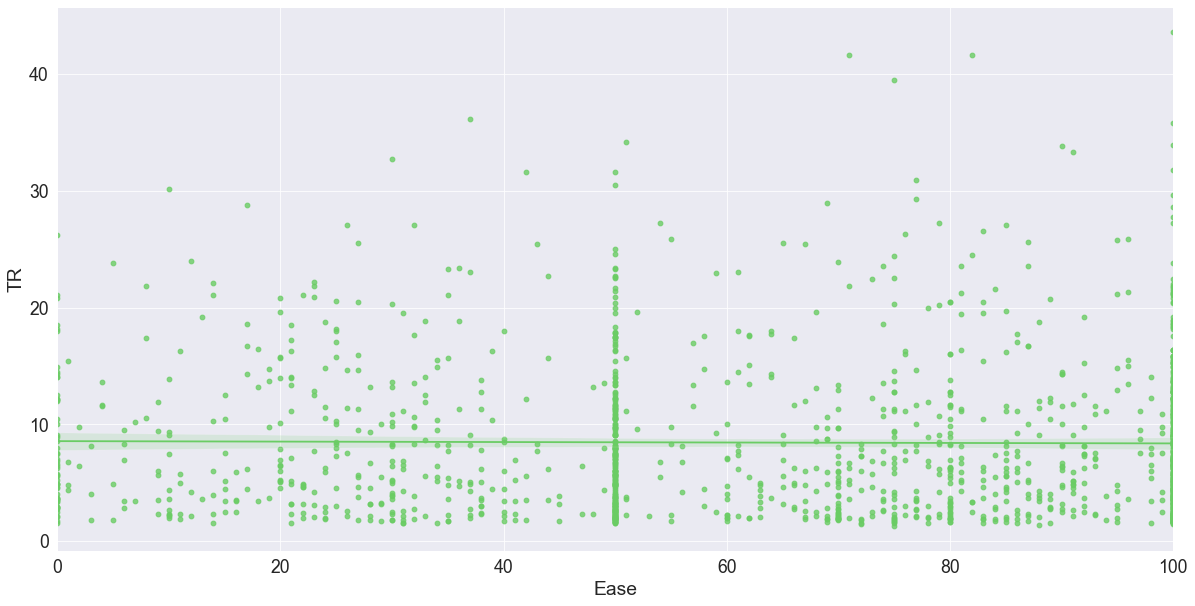

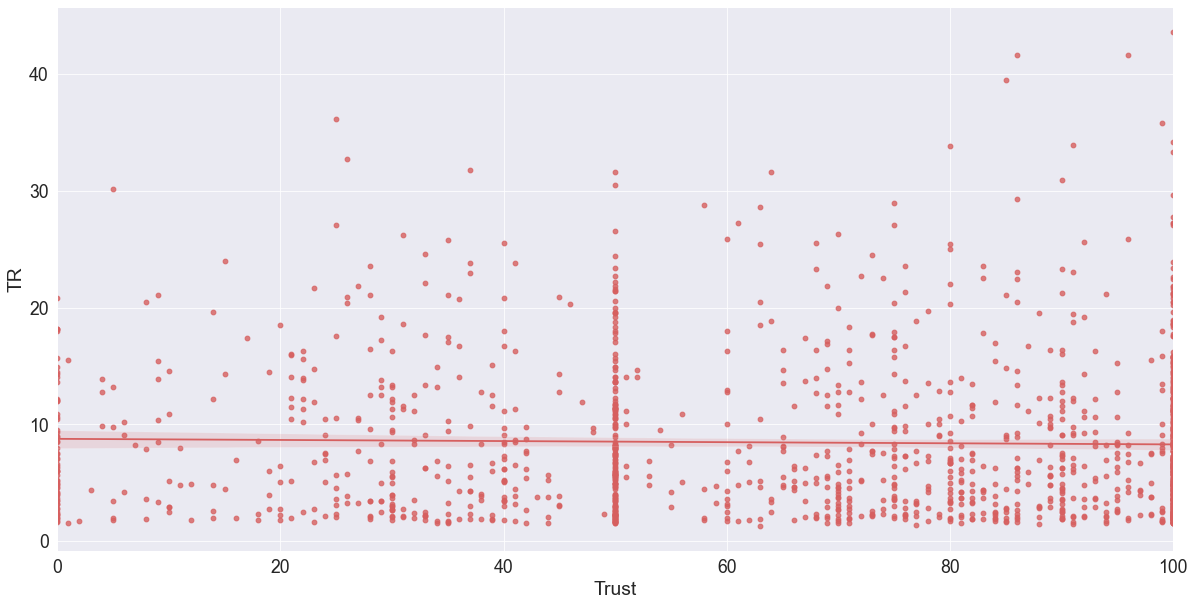

In [211]:
sns.set_context("paper", font_scale=2.0)
palette = itertools.cycle(sns.color_palette(palette="muted"))  # color palette
for col in cols_to_add:
    plt.figure(figsize=(20, 10))
#     sns.regplot(data=df, y="TR", x=col, color=next(palette), x_estimator=np.mean, robust=True, n_boot=1000)
    sns.regplot(data=df, y="TR", x=col, color=next(palette))
    plt.show()

In [178]:
# selected = df_chits[df_chits["0"] < 2671 / 2]
selected = copy.deepcopy(df_chits[[str(c) for c in range(1, 672)]])
selected

,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
0,45,15,8,9,12,2,4,2,3,3,...,0,0,0,0,0,0,0,0,0,0
1,15,7,0,2,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,62,31,13,12,9,2,9,1,3,4,...,0,0,0,0,0,0,0,0,0,0
3,23,9,2,6,4,6,4,1,2,4,...,0,0,0,0,0,0,0,0,0,0
4,7,1,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,90,25,18,17,6,10,4,4,2,3,...,0,0,0,0,0,0,0,0,0,0
7909,53,21,9,9,4,8,5,6,4,2,...,0,0,0,0,0,0,0,0,0,0
7910,43,10,2,4,5,5,3,2,1,2,...,0,0,0,0,0,0,0,0,0,0
7911,1,3,2,2,3,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
sum_cols = [str(i) for i in range(31, 672)]

selected[">1s"] = selected[sum_cols].sum(axis=1)

selected[">1s"]

0       16
1        0
2       15
3        5
4        0
        ..
7908    10
7909    14
7910     0
7911    17
7912    11
Name: >1s, Length: 7913, dtype: int64

In [13]:
selected.iloc[0].values

array([45, 15,  8,  9, 12,  2,  4,  2,  3,  3,  1,  2,  0,  0,  1,  1,  3,
        2,  1,  1,  1,  0,  0,  1,  2,  0,  0,  0,  0,  0,  0,  2,  0,  0,
        0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [13]:
selected.sum()

1      372099
2      151068
3       90222
4       62887
5       47470
        ...  
667         0
668         0
669         0
670         0
671         1
Length: 671, dtype: int64

<AxesSubplot:ylabel='Count'>

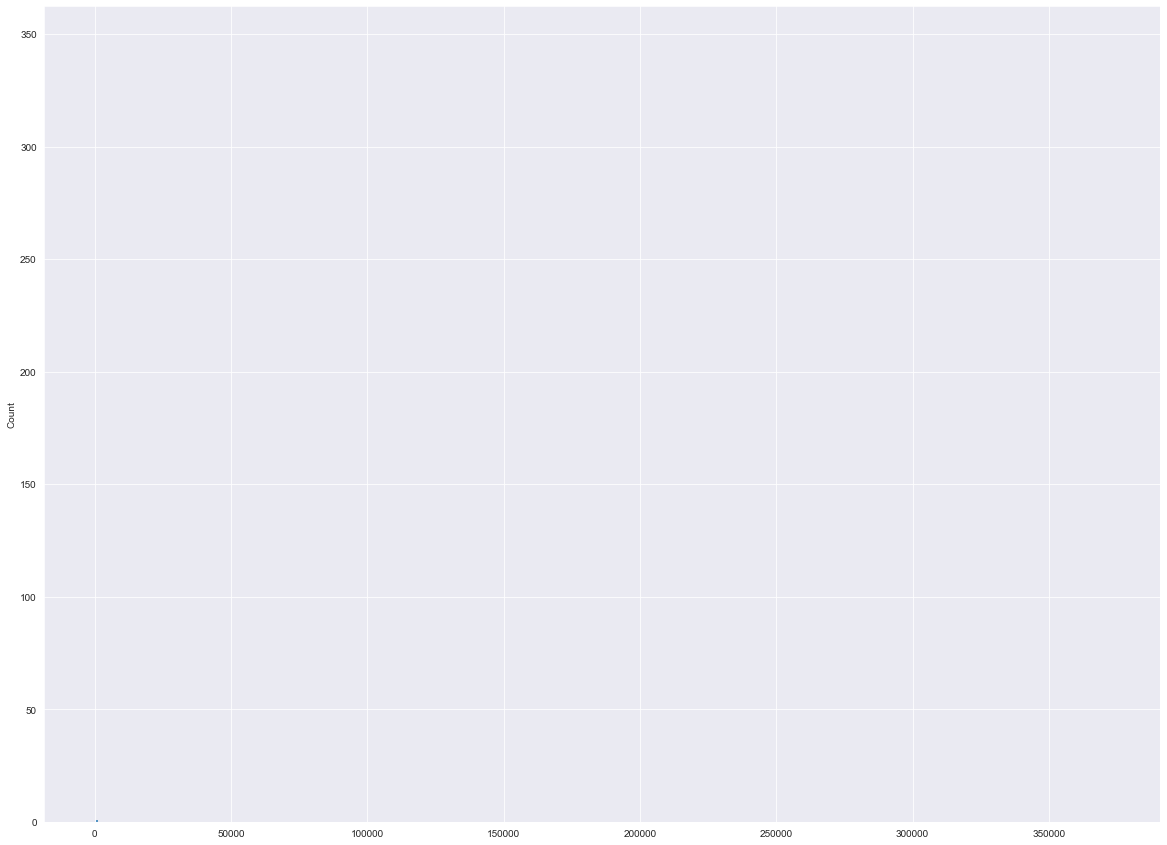

In [11]:
plt.figure(figsize=(20, 15))
# test = selected.melt()
under_cols = [str(i) for i in range(1, 31)]
test = selected[under_cols].melt()
# sns.histplot(data=test, x="variable", y="value", discrete=True)
sns.histplot(data=selected.sum())

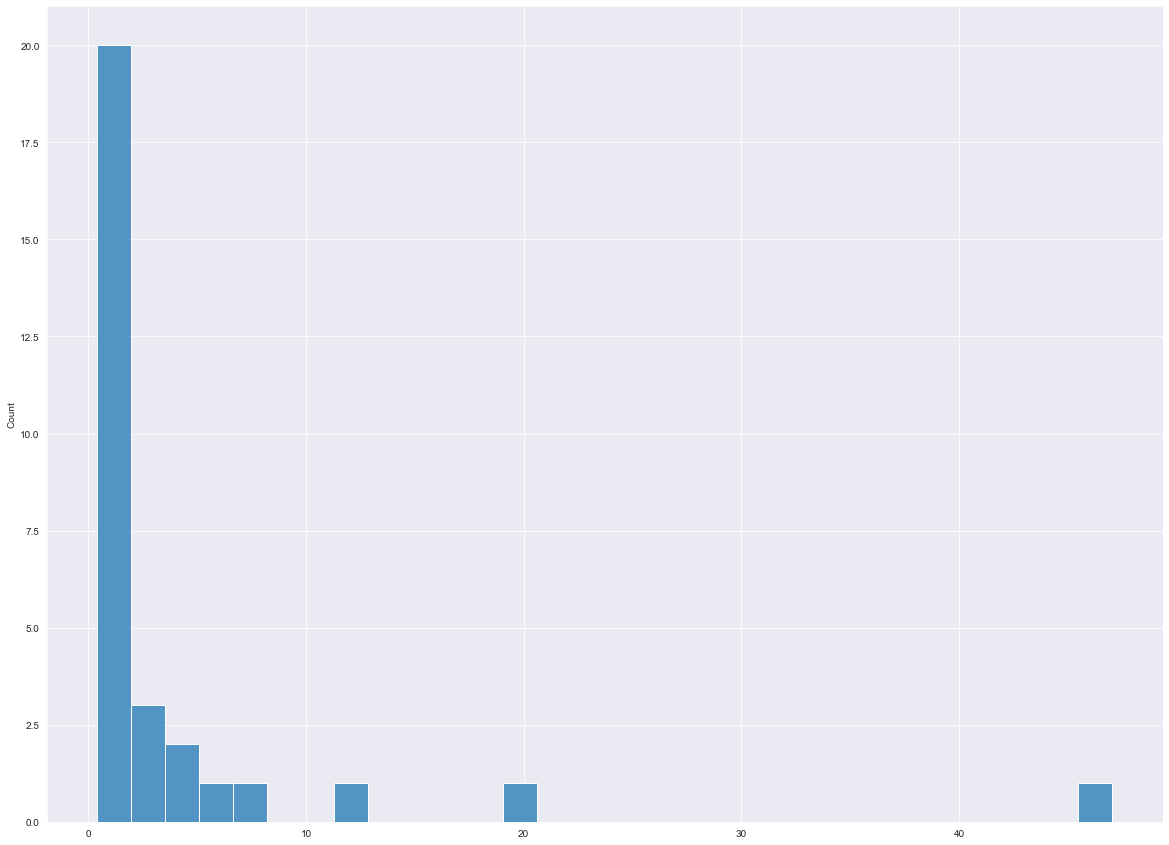

In [20]:
plt.figure(figsize=(20, 15))
x = list(selected.mean().index[:10])
y = list(selected.mean().values[:10])
sns.histplot(test[:30], bins=30)
plt.show()

In [7]:
# all columns except for nulls counter (0), and hitType
cols = list(df_chits.describe().columns.difference(["0"]))
hits_ccount = {"uid": [], "nulls": [], "hits": []}
hits_bcount = {"uid": [], "nulls": [], "hits": []}
pbar = tqdm(iterable=df_chits.index.values)
for row in pbar:
    curr_c = df_chits.loc[row]
    curr_b = df_bhits.loc[row]
    hits_ccount["uid"].append(curr_c.uid)
    hits_bcount["uid"].append(curr_b.uid)
    hits_ccount["nulls"].append(curr_c["0"])
    hits_bcount["nulls"].append(curr_b["0"])
    totalc = sum([int(col) * curr_c[col] for col in cols])
    totalb = sum([int(col) * curr_b[col] for col in cols])
    hits_ccount["hits"].append(totalc)
    hits_bcount["hits"].append(totalb)

hits_ccount = pd.DataFrame(hits_ccount)
hits_bcount = pd.DataFrame(hits_bcount)

  0%|          | 0/7913 [00:00<?, ?it/s]

In [21]:
pbar = tqdm(iterable=chits_count.index.values)
perc = {
    "c-nulls": [],
    "c-hits": [],
    "b-nulls": [],
    "b-hits": [],
}
for row in pbar:
    curr_c = hits_count.loc[row]
    nulls = curr_c.nulls
    hits = curr_c.hits
    total = nulls + hits
    nulls_per = nulls * 100 / total
    hits_per = hits * 100 / total
    if curr_c.type == "center":
        perc["c-nulls"].append(nulls_per)
        perc["c-hits"].append(hits_per)
    else:
        perc["b-nulls"].append(nulls_per)
        perc["b-hits"].append(hits_per)

print(f"Average % center nulls: {sum(perc['c-nulls'])/len(perc['c-nulls'])}")
print(f"Average % center hits: {sum(perc['c-hits'])/len(perc['c-hits'])}")
print(f"Average % box nulls: {sum(perc['b-nulls'])/len(perc['b-nulls'])}")
print(f"Average % box hits: {sum(perc['b-hits'])/len(perc['b-hits'])}")

  0%|          | 0/15826 [00:00<?, ?it/s]

Average % center nulls: 51.294452025378824
Average % center hits: 48.705547974621076
Average % box nulls: 14.41973108623297
Average % box hits: 85.58026891376635
